<a id="top"></a>
# Predicting galaxy redshift via regression on 3D-HST photometry

***

## Learning Goals


**In this tutorial, you will see an example of building and training a decision tree-based regression model to perform regression on astronomical data.**  By the end of this tutorial you will have working examples of how to apply decision trees and random forests in scikit-learn (sklearn).

## Introduction

Decision trees are a form supervised machine learning which can be used for classification or regression. In this notebook, we will walk through the basic steps of applying three types of decision tree algorithms to multi-wavelength photometric data.

1. Download and import the data
2. Perform data cleaning steps
3. Divide the data into training, validation and testing sets
4. Use a simple decision tree to perform a regression task via sklearn
5. Use a random forest to perform a regression task via sklearn
6. Consider the effects of over-fitting
8. Compare the "best" model to the state-of-the-art 

Decision trees are used in a wide range of vector analysis tasks. Here we will use them to regress galaxy redshift from its multi-wavelength photometry. We will use data from the [3D-HST](https://archive.stsci.edu/prepds/3d-hst/) survey. 


## Imports
This notebook uses the following packages:
- `numpy` to handle array functions
- `tarfile` to unpack files
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `sklearn` for machine learning tools and performance metrics

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

In [1]:
# arrays
import numpy as np

# unpacking files
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table

# plotting
from matplotlib import pyplot as plt

# sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score


# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')


### 1. Download and import the data 

First, download the 3D-HST catalog from the MAST archive. This dataset is described in [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24).

In [2]:
file_url = 'https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar'
tarfile.open(download_file(file_url, cache=True), "r:").extract('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', '.')

Read the combined photmetric catalog into a dataframe via astropy

In [3]:
tab = Table.read('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', format='ascii').to_pandas()

Now we will examine the contents of the catalog! The dataset contains standard information such as target id, field name, coordinates, fluxes, errors, and various photometric flags (see [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24), or download the [README here](https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/master_readme.v4.1.txt)). In addition, there are derived properties such as photometric redshift (`z_peak`), spectroscopic redshift (`z_spec`), mass (`lmass`) and dust extinction in the V band (`Av`). 

In [4]:
tab

,id,field,ra,dec,x,y,z_spec,z_peak,faper_F140W,eaper_F140W,...,flags,f140w_flag,star_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w,lmass,Av
0,1.0,AEGIS,215.222382,53.004185,9590.50,3057.30,-1.0000,0.0100,-82.0410,-82.041000,...,0,0,1,0,0,2,0,3,7.51,1.1
1,2.0,AEGIS,215.096588,52.918053,16473.20,3150.20,-1.0000,0.0100,3.5078,0.074233,...,3,0,0,0,0,4,4,4,5.62,0.1
2,3.0,AEGIS,215.161469,52.959461,13060.10,2982.30,-1.0000,0.2062,-1.9043,-1.904300,...,1,0,0,1,0,2,0,2,9.00,1.1
3,4.0,AEGIS,215.305298,53.052921,5422.80,2692.10,-1.0000,0.0355,-72.3250,-72.325000,...,0,0,0,0,0,1,0,1,4.78,0.4
4,5.0,AEGIS,215.041840,52.871273,19894.60,2834.40,-1.0000,0.3427,1890.5000,0.133300,...,0,1,2,0,1,0,3,0,11.57,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207962,44098.0,UDS,34.363106,-5.122067,14578.84,11076.42,-1.0000,0.1852,188.8200,0.170750,...,0,1,2,0,0,0,3,0,10.21,0.2
207963,44099.0,UDS,34.333569,-5.123219,16343.92,11007.12,-1.0000,0.6716,1.7193,0.129080,...,0,1,2,0,0,0,3,0,8.49,0.7
207964,44100.0,UDS,34.363682,-5.123123,14544.39,11013.01,1.4196,2.7489,1.3829,0.113830,...,0,1,2,0,0,0,4,0,9.08,1.4
207965,44101.0,UDS,34.556389,-5.123040,3028.23,11017.04,-1.0000,1.1716,-99.0000,-99.000000,...,1,0,0,0,0,1,0,2,10.55,1.0


In [5]:
tab.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

### 2. Perform data cleaning steps

Before building and applying a regression model, we first need to inspect and clean the dataset. 

To explore the physical parameters of the sample, we plot the spectroscopic redshift vs. the mass derived from the [FAST](https://ui.adsabs.harvard.edu/abs/2018ascl.soft03008K/abstract) phototmetric fit:

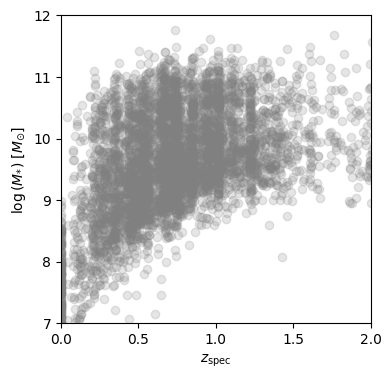

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(tab.z_spec, tab.lmass, alpha=0.2, color='grey')
ax.set_xlim(0, 2)
ax.set_ylim(7, 12)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$\log{(M_{*})}\,\,[M_{\odot}]$')

plt.show()

By inspection of this plot, we will only keep sources with log(M)>9 to remove sources which do not have complete coverage across redshift.

In [7]:
tab = tab[tab.lmass > 9].copy()

We're interested in predicting redshift, so our "target" variable will be z_spec. The "features" will be all columns except for the spectroscopic and photometric redshifts.

In [8]:
target = 'z_spec'
features = [col for col in tab.columns if (col != target)]

Next, we will make histograms of each input to gain an intuition for the distribution of each feature.

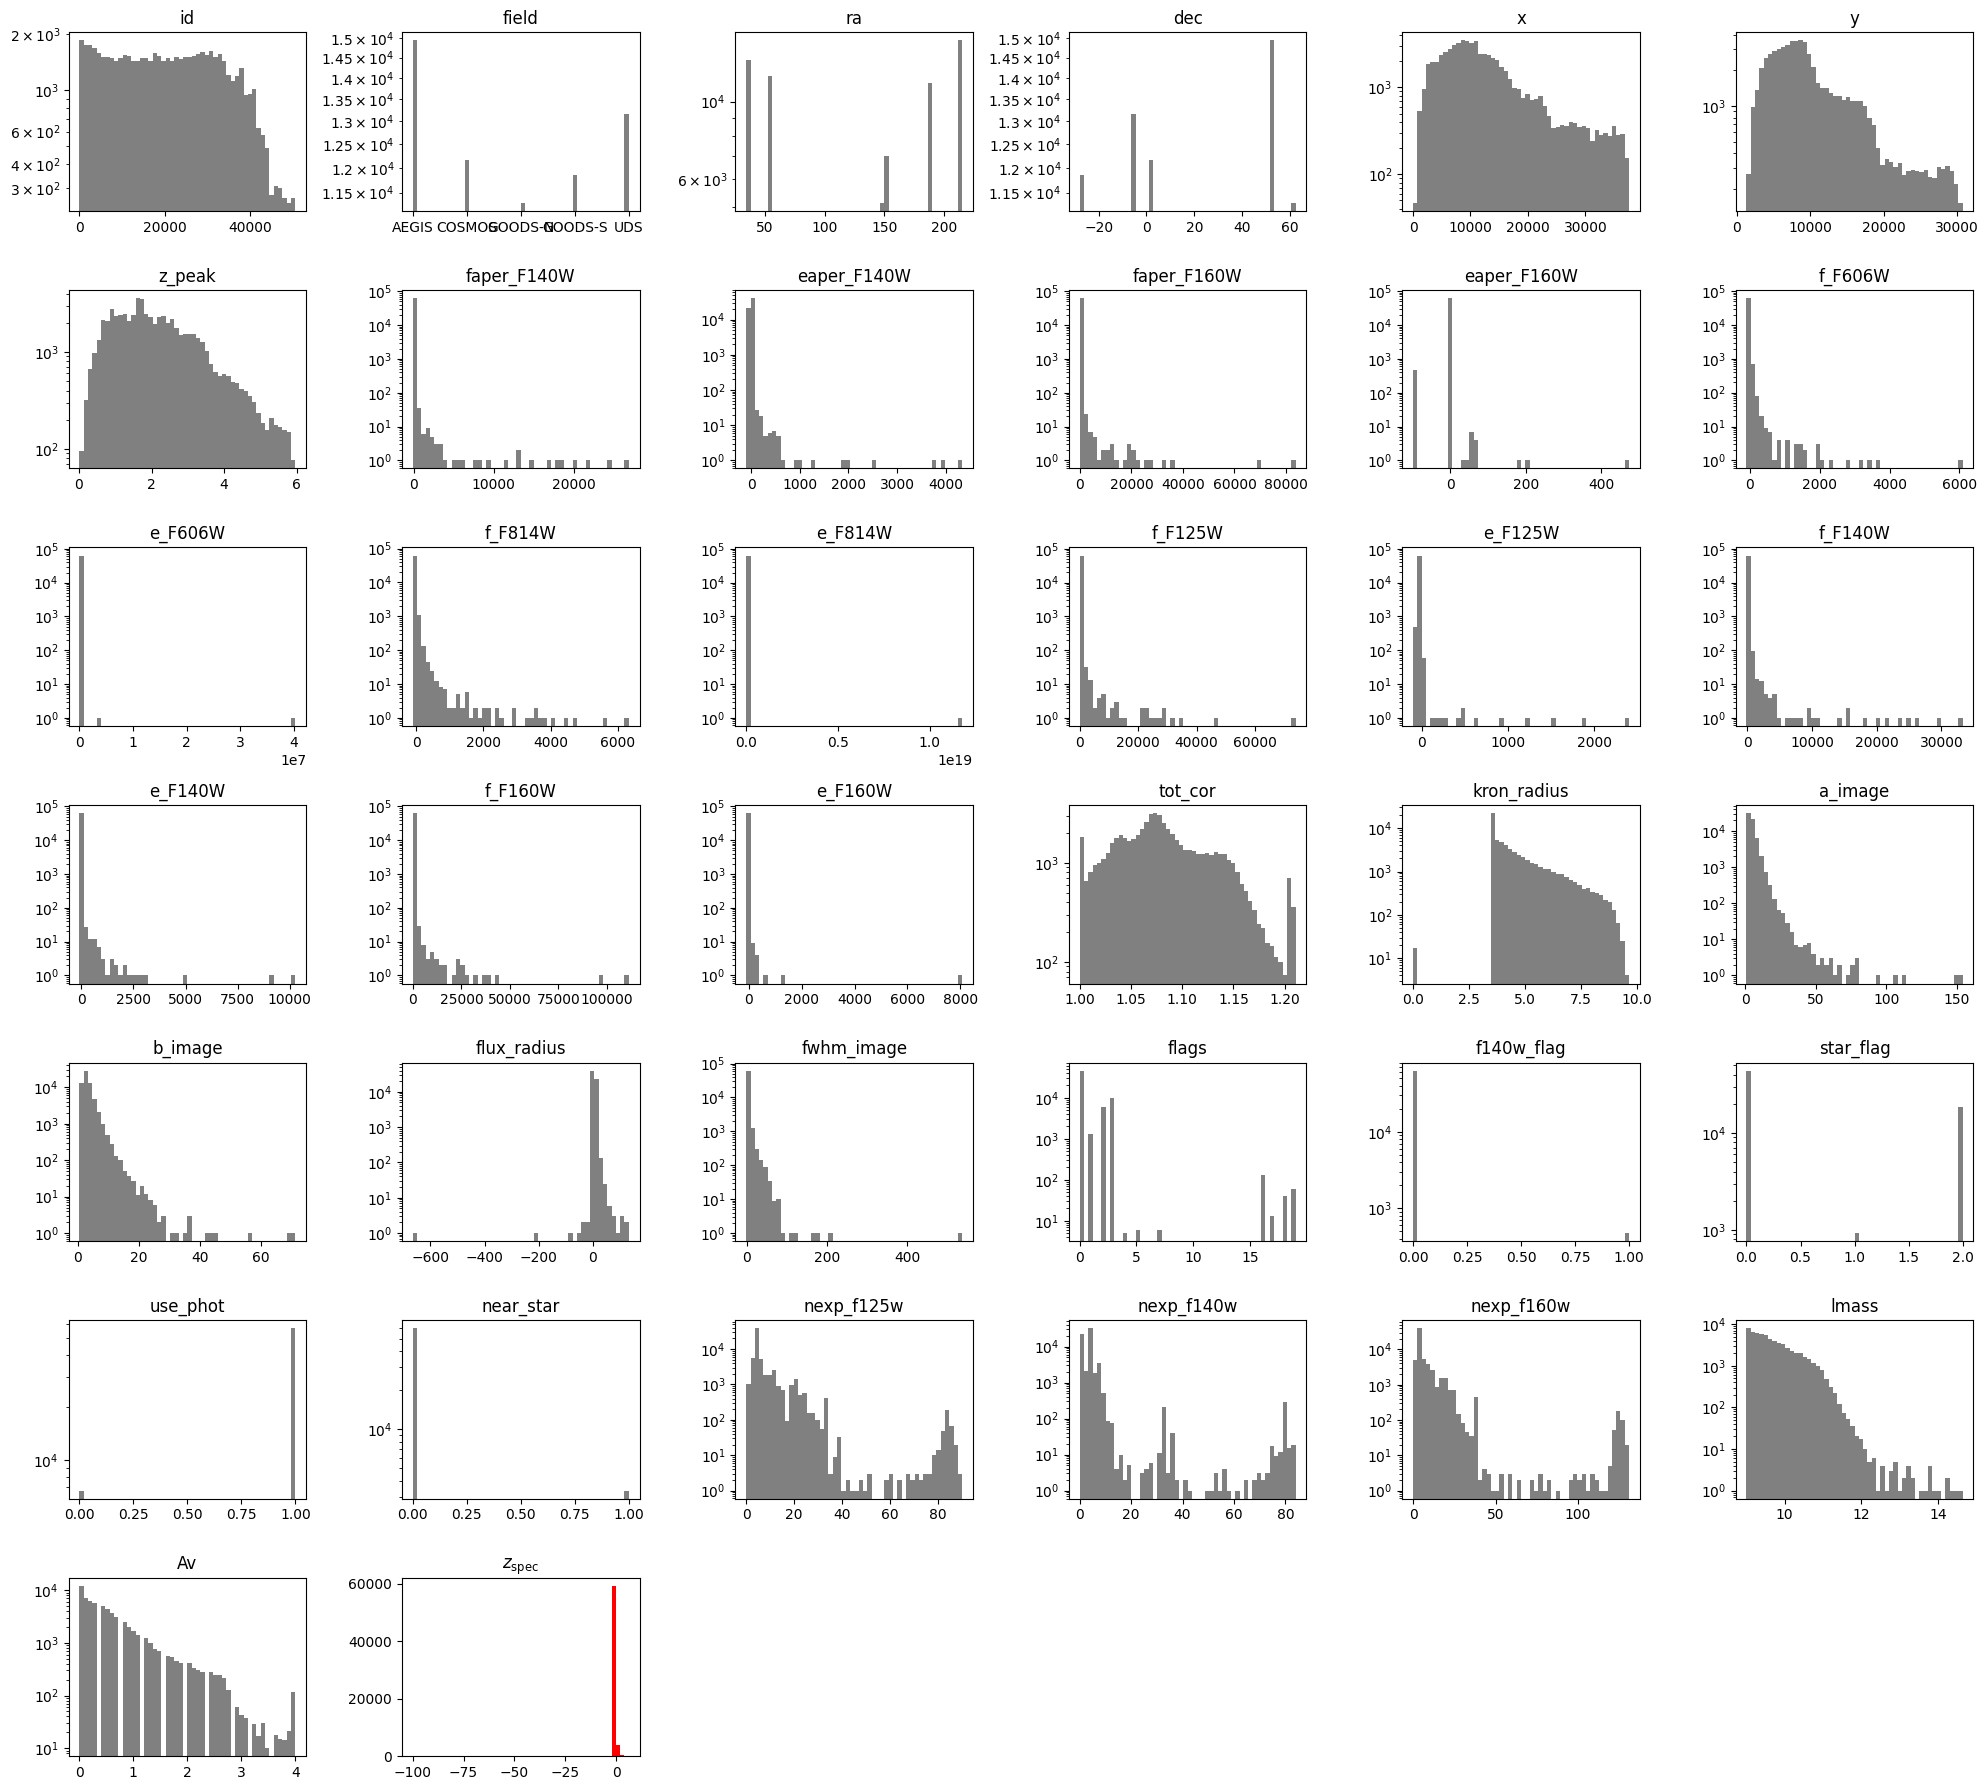

In [9]:
fig = plt.figure(0, [20,18])

for k, feat in enumerate(features):
    ax = fig.add_subplot(7, 6, k+1)
    ax.hist(tab[feat], bins=50, log=True, color='grey')
    ax.set_title(feat)

ax = fig.add_subplot(7, 6, len(features)+1)
ax.hist(tab[target], bins=50, color='red')
ax.set_title(r'$z_{\rm spec}$')

plt.tight_layout()
plt.show()

The 'Av', 'lmass' and 'z_peak' values were all computed via FAST photometric fit, and so we will exclude them as well. In addition, we will exclude the categorical flag variables ('flags', 'f140w_flag', 'star_flag', 'use_phot', 'near_star').

In [10]:
features = [col for col in features if (col != 'Av') and (col != 'lmass') and (col != 'z_peak') 
            and (col != 'flags') and (col != 'f140w_flag') and (col != 'star_flag') 
            and (col != 'use_phot') and (col != 'near_star')]
           

Next, we will remove sources which have no constraints for our target variable:

In [11]:
tab = tab[(tab[target] > 0)] 

Next, we will encode the 'field" variable,

In [12]:
label_encoder = LabelEncoder()
tab['field'] = label_encoder.fit_transform(tab['field'])

Finally we will impute missing values of photometric errors (set to -99. in the table) by assigning them the median of the distribution:

In [13]:
errors = [col for col in features if (col[:1] == 'e') and (col[-1:] == 'W')]

for error in errors:
    tab[error] = np.where(tab[error] < -90, tab[error].median(), tab[error])

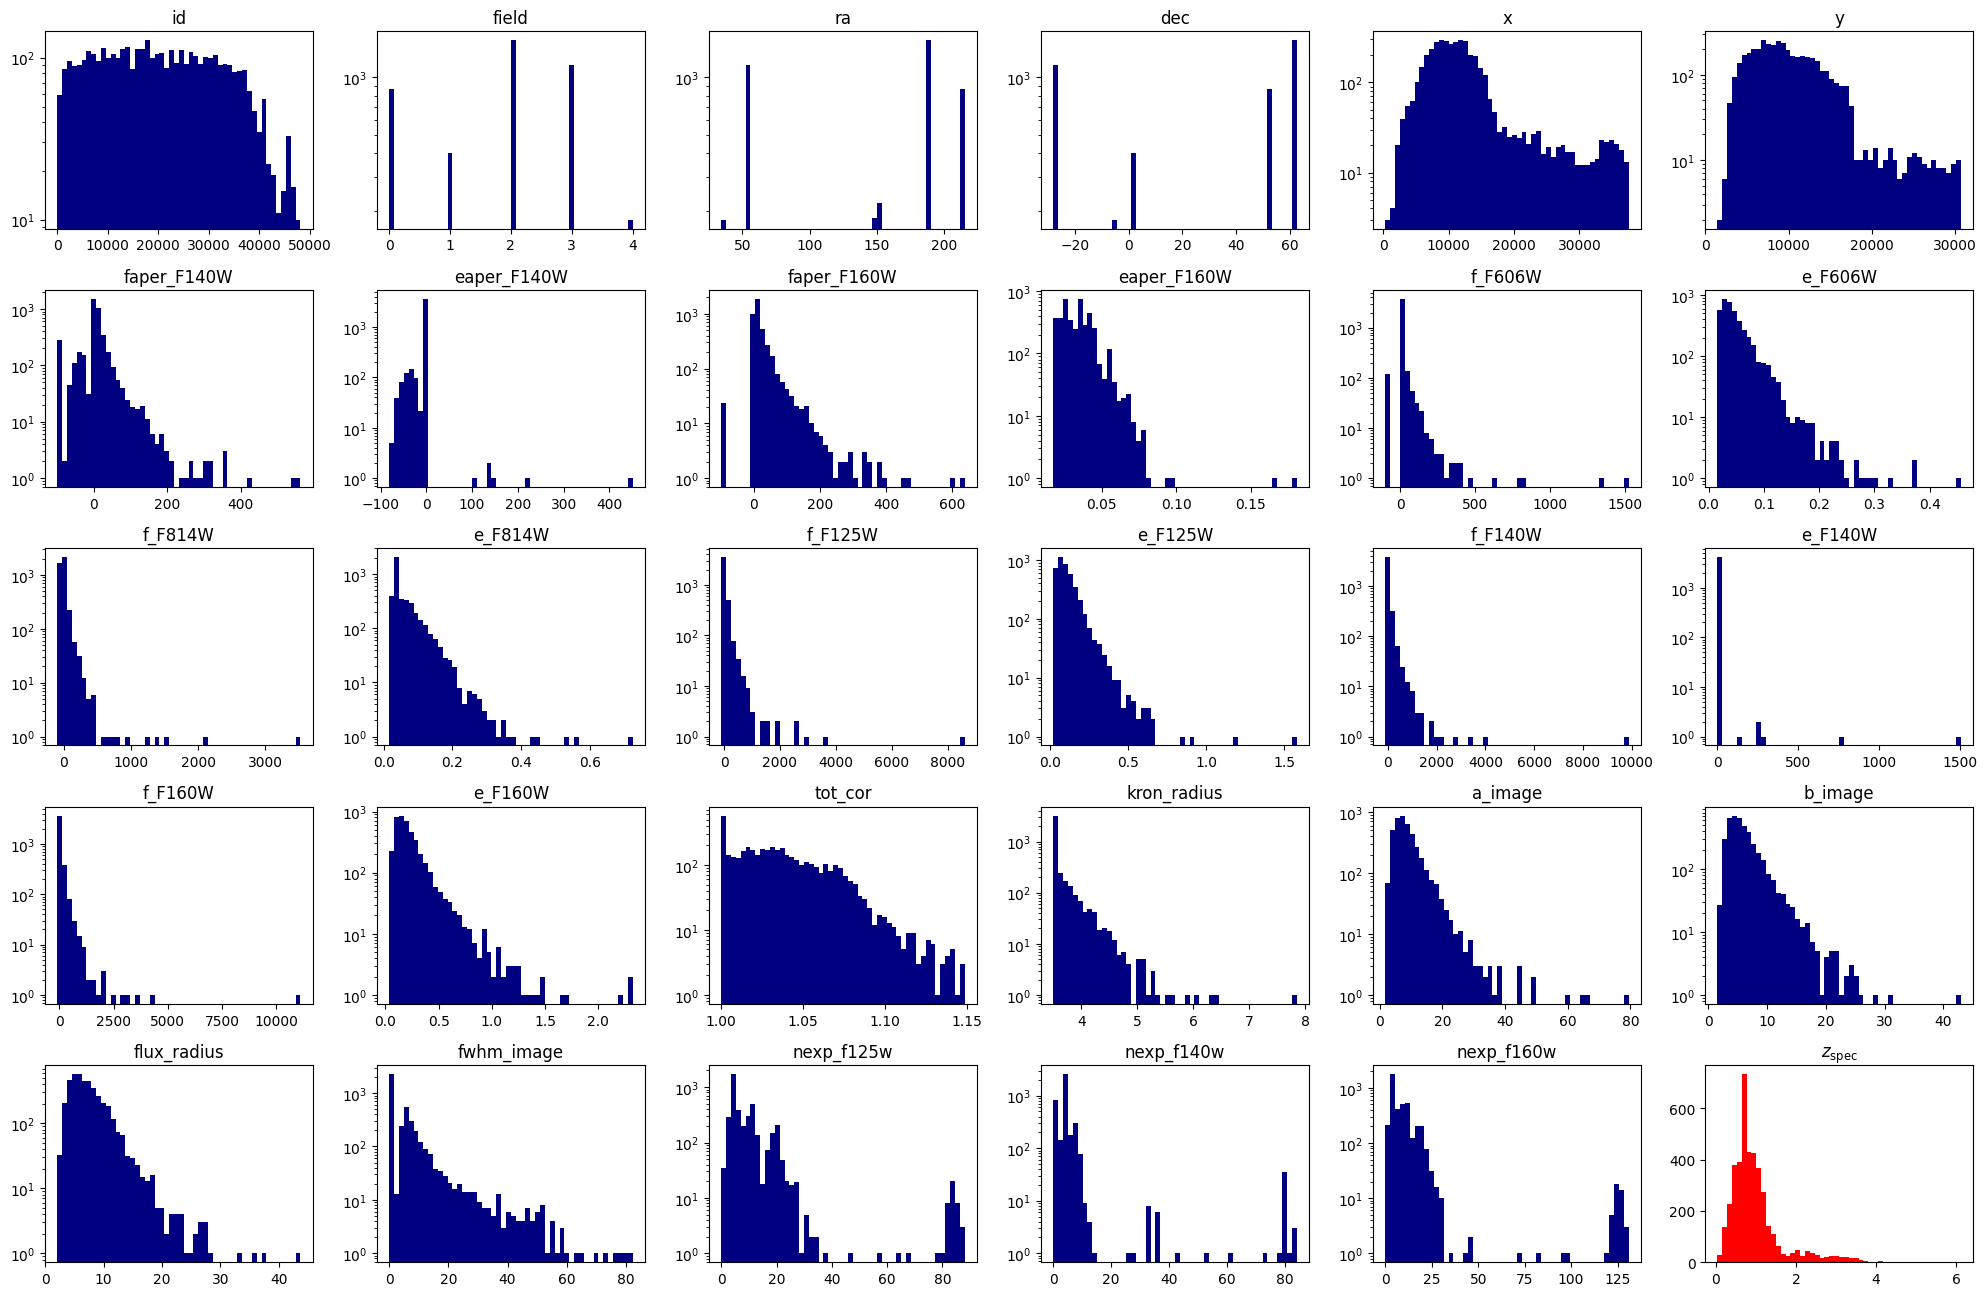

In [14]:
fig = plt.figure(0, [20, 18])

for k, feat in enumerate(features):
    ax = fig.add_subplot(7, 6, k+1)
    ax.hist(tab[feat], bins=50, log=True, color='navy')
    ax.set_title(feat)

ax = fig.add_subplot(7, 6, len(features)+1)
ax.hist(tab[target], bins=50, color='red')
ax.set_title(r'$z_{\rm spec}$')

plt.tight_layout()
plt.show()

### 3. Divide the data into train, test and validation sets

First, define the independent (X) and dependent (y) variables from the dataset

In [15]:
X = tab[features].values
y = tab[target].values

Divide the data into train, validation and test sets. We will use the following definitions:

- **Training**: The data used to update *model parameters* (e.g., coefficients or matrix element values).
- **Valdiation**: The data used to update *model selection* (for instance, we might change *hyperparameters* of a model based on the validation metrics).
- **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

In [16]:
indices = np.arange(len(y))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(X, y, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

### 4. Decision tree regression

Using sklearn, we can very easily construct a decision tree model for regressing redshift from the photometric catalog features. A decision tree is composed of a series of `if-else` decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision. In this first example, we will use the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn`.

In [17]:
# Initialize the model
dtree = DecisionTreeRegressor()

# Fit the model parameters using the training dataset
dtree.fit(X_train, y_train)

DecisionTreeRegressor()

To quantify the performance of the model, we will apply it to the validation set and compare the predicted values with the true values by computing the mean squared error:

MSE = 0.2413


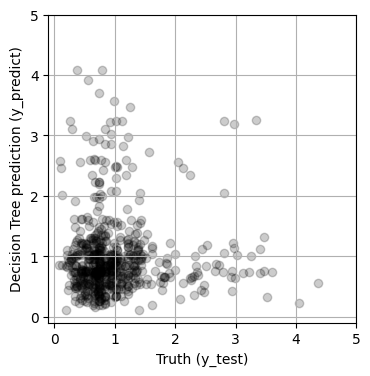

In [18]:
y_predict = dtree.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

Hmm, maybe we can do better by tuning the parameters of the model. Decision trees have many parameters, such as the maximum number of decisions (`max_depth`), the minimum number of samples required to create a split a node (`min_samples_split`) and the minimum number of samples required to be at a node leaf (`min_samples_leaf`). All available parameters are listed below, and are described in the [sklearn documenation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

In [19]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])

Selecting the optimal values of these parameters is sometimes done via targeted grid search, and can also be done via random search, which we will implement here

In [20]:
hyperparameter_distributions = {
    'max_depth': np.arange(1, 20, 2).astype(int),
    'min_samples_split': np.arange(5, 105, 10).astype(int),
    'min_samples_leaf': np.arange(5, 105, 10).astype(int)
}

random_search = RandomizedSearchCV(
    dtree, 
    param_distributions=hyperparameter_distributions,
    n_iter=100
)

random_search.fit(X_train, y_train.flatten())

RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_leaf': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'min_samples_split': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])})

In [21]:
print(random_search.best_params_)

{'min_samples_split': np.int64(35), 'min_samples_leaf': np.int64(45), 'max_depth': np.int64(17)}


MSE = 0.1556


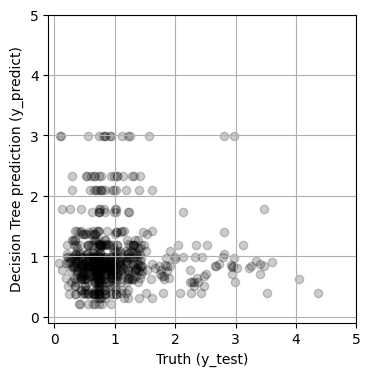

In [22]:
y_predict = random_search.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

The model improved somewhat with hyperparameter tuning (i.e., the MSE decreased), but the results still looks pretty bad. We'll try another model next!

### 5. Random forest regression

A random forest is an algorithm composed of many decision trees. Trained via supervised machine learning, random forests are used for both classification and regression tasks. Here we'll apply a random forest to regress redshift from 3D-HST photometry, and compare the results to the simple decision tree in Section 4. We will use the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) from `sklearn`.

In [23]:
# use the same parameters as the Decision Tree
params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
    "max_depth": 15,
}

# Initialize the model
rf = RandomForestRegressor(**params)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15)

MSE = 0.1152


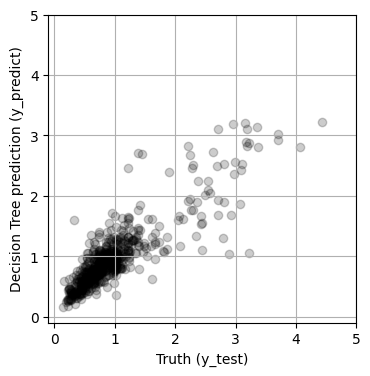

In [24]:
y_predict = rf.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(y_test, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Decision Tree prediction (y_predict)')
plt.show()

### 6. Test for over-fitting

The results are much improved by the random forest! **However, we must be cautious!** It is possible that this model suffers from over-fitting. To visualize overfitting, we can compare the mean squared error (MSE) for models of increasing `max_depth` on the training and testing sets:

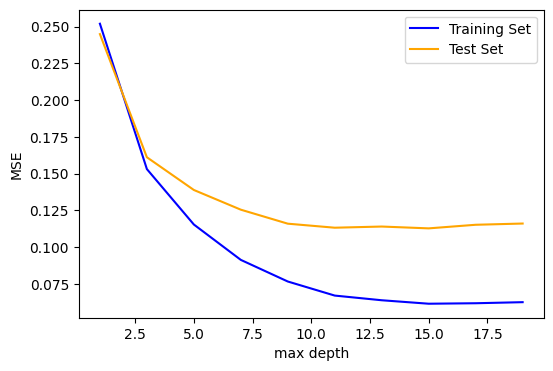

In [25]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []
for depth in max_depths:

    params = {
        "min_samples_split": 15,
        "min_samples_leaf": 5,
        "max_depth": depth,
    }
    rff = RandomForestRegressor(**params)
    rff.fit(X_train, y_train)
    
    y_predict_train = rff.predict(X_train)
    y_predict_test = rff.predict(X_test)
    
    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))

    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

plt.show()

Beyond a max_depth of ~10, the MSE on the training set declines while the MSE on the test set flattens out, suggesting some amount of over-fitting. 

To explore further, we will explore how general our model performance (here quantifed with MSE) is using k-fold cross-validation via `sklearn`. In practice, the X and y datasets are split into k "folds", and over k iterations, the model is trained using k-1 folds as training data and the remaining fold as a test set to compute performace (i.e., MSE).

In [26]:
cv = cross_validate(
    estimator=rf, 
    X=X, 
    y=y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.146 +/- 0.057


The best-fit MSE is consistent with the cross-validated MSE, suggesting that the model is not significantly over-fitting.

Next, we'll observe which features are most important to the model predictions with the [`feature_importances`](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

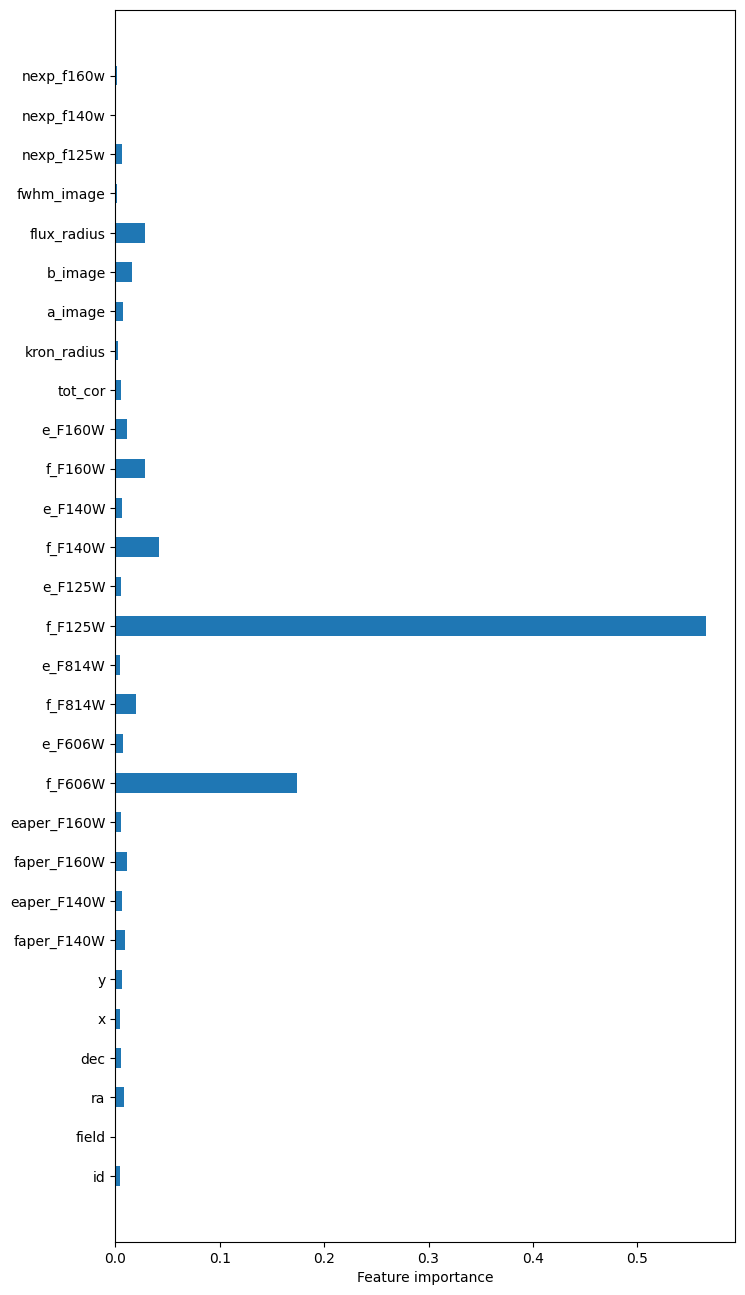

In [27]:
importances = rf.feature_importances_

fig = plt.figure(0, [8, 16])
ax = fig.add_subplot(111)
ax.barh(np.arange(X.shape[1]), importances, 
        align='center', 
        height=0.5, 
        tick_label=features)
ax.set_xlabel("Feature importance")

plt.show()

The most "important" features in this model are the F125W and F606W fluxes. Parameters such as id, ra, dec, x, and y understandably have very little influence on the predictions.

### 7. Compare to the state of the art

A crucial step in the process of constructing a machine learning model is to consider how the results compare to the state of the art. In this case, we can compare the predictions from our random forest model to the results of detailed modeling of the photometric redshift (`z_peak`). 

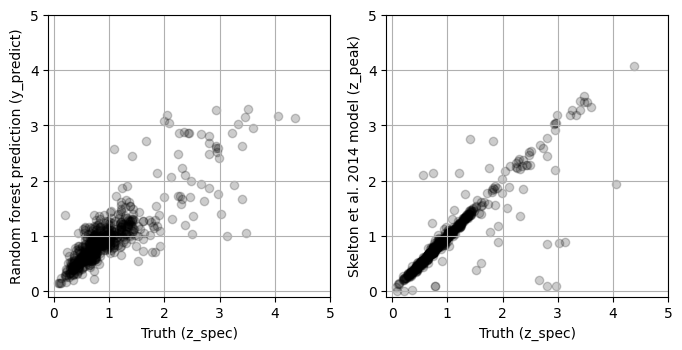

In [28]:
y_predict_validate = rf.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('Random forest prediction (y_predict)')

ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')

plt.show()

Comparing the MSE for the results above:

In [29]:
print(f"Random forest MSE = {mean_squared_error(y_validate, y_predict_validate):.4f}")
print(f"Skelton et al. (2014) MSE = {mean_squared_error(y_validate, y_skelton2014):.4f}")

Random forest MSE = 0.1396
Skelton et al. (2014) MSE = 0.0928


Clearly, the Skelton et al. (2014) model out performs the random forest!

## FAQs

- **How do I interpret these results?** Overall, although the random forest model is not significantly over-fitting, it performs much worse than the ([Skelton et al. 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24)) model. We can concluded that this particular random forest model is **not** a good choice for predicting galaxy redshift. However, an important difference between these two models is that this random forest only uses photometric bands (F606W, F816W, F125W, F140W, and F160W) while Skelton et al. (2014) uses upwards of 15 photometric bands! 


- **How can I improve the results of the model?** There are several strategies to try. You can explore changes to the current models, including parameter grid searches, or [pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html). Finally you can apply additional "feature engineering", for example selecting different subsets of features or exploring how to improve the data cleaning. 


- **Why hasn't anyone used this dataset for this purpose before?** The 3D-HST dataset was not constructed for machine learning purposes, but it is a feature-rich, relatively compact dataset for trying out new methods, even if they are not all successful. We encourage you to explore the rest of the [high-level science product](https://archive.stsci.edu/prepds/3d-hst/) for more ideas!


- **I want to test my model on my training data!** No. You will convince yourself that your results are much better than they actually are.  Always keep your training, validation, and testing sets completely separate!

## Extensions / Exercises

- **Upgrade the analysis by including new features!** For example, if you include galaxy colors (e.g., F125W-F140W, F140W-F160W, F606W-F125W) do the model results improve? Can you think of other features to include?


- **Tune the model parameters with a grid search** Do the Random Forest model results improve if you implement a random grid search over hyperparameters as we did for the Decision Tree model? 


- **Try other models** Explore `sklearn` and try out other regression models, such as gradient-boosted trees. 



## About this Notebook

**Author:**  
Claire Murray, Assistant Astronomer, cmurray1@stsci.edu  


**Info:**  
This notebook is based on the machine learning tutorials by John F. Wu, Assistant Astronomer, (STScI).


**Updated On:** 2022-5-25

## Citations

If you use this data set, `astropy`, or `sklearn` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://ui.adsabs.harvard.edu/abs/2014ApJS..214...24S/abstract)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `sklearn`](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)



[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 